In [1]:
%env CUBLAS_WORKSPACE_CONFIG=:16:8

env: CUBLAS_WORKSPACE_CONFIG=:16:8


In [2]:
from autoencodix.utils.example_data import (
    EXAMPLE_MULTI_BULK,
    EXAMPLE_MULTI_SC,
    EXAMPLE_PROCESSED_DATA,
)

# EXAMPLE_DATA hold PyTorch Datasets (child with extra info) with metdata for train, test and valid splits
processed_data = EXAMPLE_PROCESSED_DATA
raw_bulk = EXAMPLE_MULTI_BULK
raw_sc = EXAMPLE_MULTI_SC

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
EXAMPLE_PROCESSED_DATA.train.metadata

,cluster,age,size,density,category,random_feature,sample_id
0,0,21.194224,4.538300,0.113699,A,-0.657083,sample_303
1,0,23.930016,6.864434,0.086318,A,1.280058,sample_259
2,3,53.074559,12.812042,1.111816,D,-0.046288,sample_717
3,4,53.380117,12.875572,0.525779,C,0.578705,sample_127
4,0,33.724569,2.429471,0.038608,B,0.657419,sample_576
...,...,...,...,...,...,...,...
694,0,28.165998,6.223125,0.286763,E,0.047880,sample_578
695,1,31.830988,4.929979,0.456122,B,0.126054,sample_946
696,2,40.607502,6.923138,2.313312,B,-0.288755,sample_284
697,0,40.449944,0.831899,0.096780,C,1.070726,sample_462


In [4]:
import autoencodix as acx
from autoencodix.utils.default_config import DefaultConfig

In [6]:
vanillix = acx.Vanillix(config=DefaultConfig(epochs=200, learning_rate=0.005,n_layers=1, latent_dim=2), data=processed_data)
vanillix.run()
vanillix.show_result()

cpu not relevant here
Epoch 1/200, Train Loss: 1.2603, Sub Losses: recon_loss: 1.2603
Valid Loss: 1.4729, Sub Losses: recon_loss: 1.4729
Epoch 2/200, Train Loss: 1.1599, Sub Losses: recon_loss: 1.1599
Valid Loss: 1.3290, Sub Losses: recon_loss: 1.3290
Epoch 3/200, Train Loss: 1.0478, Sub Losses: recon_loss: 1.0478
Valid Loss: 1.1643, Sub Losses: recon_loss: 1.1643
Epoch 4/200, Train Loss: 0.9357, Sub Losses: recon_loss: 0.9357
Valid Loss: 1.0376, Sub Losses: recon_loss: 1.0376
Epoch 5/200, Train Loss: 0.8506, Sub Losses: recon_loss: 0.8506
Valid Loss: 0.9382, Sub Losses: recon_loss: 0.9382
Epoch 6/200, Train Loss: 0.7798, Sub Losses: recon_loss: 0.7798
Valid Loss: 0.8670, Sub Losses: recon_loss: 0.8670
Epoch 7/200, Train Loss: 0.7427, Sub Losses: recon_loss: 0.7427
Valid Loss: 0.7830, Sub Losses: recon_loss: 0.7830
Epoch 8/200, Train Loss: 0.6881, Sub Losses: recon_loss: 0.6881
Valid Loss: 0.7315, Sub Losses: recon_loss: 0.7315
Epoch 9/200, Train Loss: 0.6486, Sub Losses: recon_loss: 0

Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x300ec7640>
Traceback (most recent call last):
  File "/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/llvmlite/binding/executionengine.py", line 182, in _raw_object_cache_notify
    if self._object_cache_notify is None:
KeyboardInterrupt: 
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/maximilianjoas/.local/share/uv/python/cpython-3.10.4-macos-aarch64-none/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/maximilianjoas/.local/share/uv/python/cpython-3.10.4-macos-aarch64-none/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/__init__.py", line 9, in <module>
    from .vanillix import Vanilli

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/5y/4yr_9t4x5zgf77_zw1krm4vw0000gn/T/ipykernel_47292/1140967836.py", line 2, in <module>
    vanillix.run()
  File "/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py", line 850, in run
    self.fit()
  File "/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_utils.py", line 199, in wrapper
    return func(self, *args, config=final_config, **func_specific_kwargs)
  File "/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py", line 473, in fit
    trainer_result = self._trainer.train()
  File "/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/trainers/_general_trainer.py", line 76, in train
    for _, (

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/maximilianjoas/.local/share/uv/python/cpython-3.10.4-macos-aarch64-none/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/maximilianjoas/.local/share/uv/python/cpython-3.10.4-macos-aarch64-none/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/torch/multiprocessing/reductions.py", line 514, in rebuild_storage_filename
    storage = torch.UntypedStorage._new_shared_filename_cpu(manager, handle, size)
RuntimeError: Connection refused


In [ ]:
categorical_clusters = ["Cluster_"+str(c) for c in EXAMPLE_PROCESSED_DATA.train.metadata.cluster]
categorical_clusters

['Cluster_0',
 'Cluster_0',
 'Cluster_3',
 'Cluster_4',
 'Cluster_0',
 'Cluster_4',
 'Cluster_4',
 'Cluster_2',
 'Cluster_2',
 'Cluster_3',
 'Cluster_0',
 'Cluster_1',
 'Cluster_4',
 'Cluster_3',
 'Cluster_3',
 'Cluster_1',
 'Cluster_3',
 'Cluster_0',
 'Cluster_0',
 'Cluster_3',
 'Cluster_3',
 'Cluster_0',
 'Cluster_1',
 'Cluster_4',
 'Cluster_0',
 'Cluster_1',
 'Cluster_0',
 'Cluster_3',
 'Cluster_4',
 'Cluster_3',
 'Cluster_1',
 'Cluster_2',
 'Cluster_2',
 'Cluster_2',
 'Cluster_1',
 'Cluster_0',
 'Cluster_4',
 'Cluster_0',
 'Cluster_2',
 'Cluster_1',
 'Cluster_3',
 'Cluster_3',
 'Cluster_4',
 'Cluster_2',
 'Cluster_2',
 'Cluster_4',
 'Cluster_3',
 'Cluster_4',
 'Cluster_4',
 'Cluster_2',
 'Cluster_4',
 'Cluster_1',
 'Cluster_0',
 'Cluster_3',
 'Cluster_2',
 'Cluster_0',
 'Cluster_2',
 'Cluster_4',
 'Cluster_0',
 'Cluster_0',
 'Cluster_3',
 'Cluster_0',
 'Cluster_1',
 'Cluster_4',
 'Cluster_4',
 'Cluster_3',
 'Cluster_4',
 'Cluster_1',
 'Cluster_1',
 'Cluster_1',
 'Cluster_1',
 'Clus

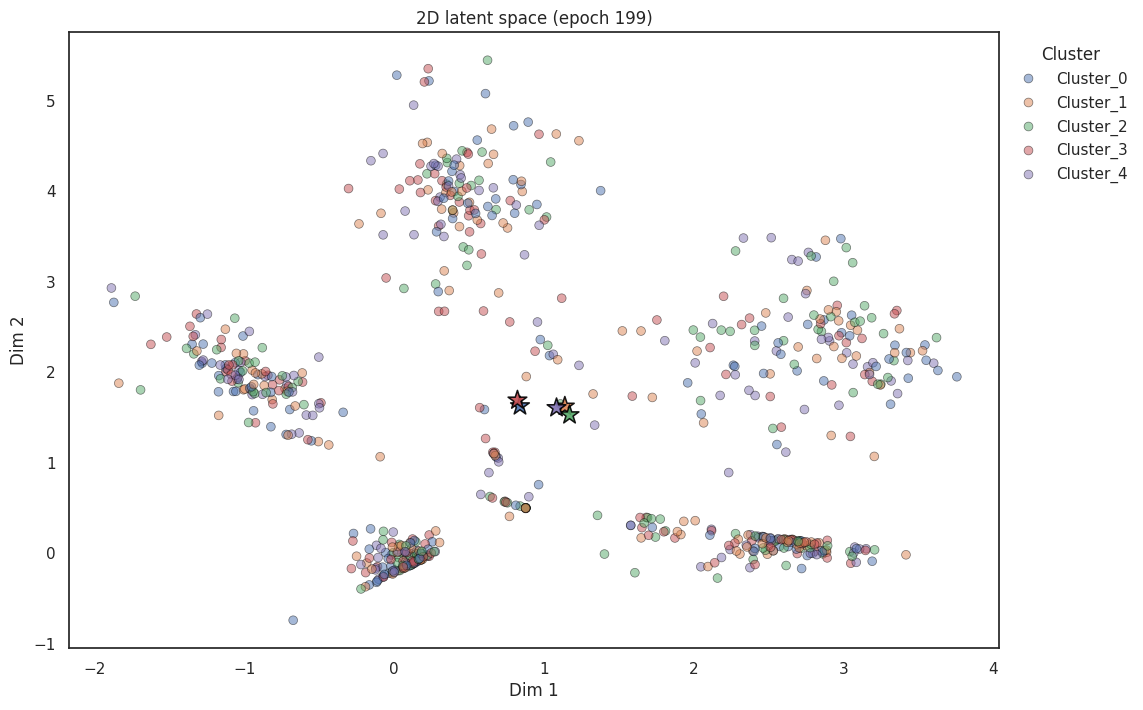

In [ ]:
vanillix._visualizer.show_latent_space(result=vanillix.result,plot_type="2D-scatter", split="train", label_list=categorical_clusters, param="Cluster")
## Problem: during training sample order is shuffled due to batching. Order cannot be recovered with current result object.

In [ ]:
vanillix.result.model

VanillixArchitecture(
  (_encoder): Sequential(
    (0): Linear(in_features=30, out_features=7, bias=True)
    (1): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=7, out_features=2, bias=True)
  )
  (_decoder): Sequential(
    (0): Linear(in_features=2, out_features=7, bias=True)
    (1): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=7, out_features=30, bias=True)
  )
)

## Ontix

In [1]:
import autoencodix as acx
from autoencodix.utils.default_config import DefaultConfig

from autoencodix.utils.example_data import (
    EXAMPLE_MULTI_BULK,
    EXAMPLE_MULTI_SC,
    EXAMPLE_PROCESSED_DATA,
)

# EXAMPLE_DATA hold PyTorch Datasets (child with extra info) with metdata for train, test and valid splits
processed_data = EXAMPLE_PROCESSED_DATA


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

ont_lvl1 = dict()
ont_lvl2 = dict()

ont_lvl1["pwy-1"] = ["sub-pwy-1", "sub-pwy-2"]
ont_lvl1["pwy-2"] = ["sub-pwy-2"]
ont_lvl1["pwy-3"] = ["sub-pwy-1", "sub-pwy-3"]
# first third of feature ids in processed_data.train.feature_ids
ont_lvl2["sub-pwy-1"] = processed_data.train.feature_ids[: int(len(processed_data.train.feature_ids) / 3)]
# second third of feature ids in processed_data.train.feature_ids
ont_lvl2["sub-pwy-2"] = processed_data.train.feature_ids[
	int(len(processed_data.train.feature_ids) / 3) : int(2 * len(processed_data.train.feature_ids) / 3)
]
# last third of feature ids in processed_data.train.feature_ids
ont_lvl2["sub-pwy-3"] = processed_data.train.feature_ids[
	int(2 * len(processed_data.train.feature_ids) / 3) : int(len(processed_data.train.feature_ids))
]

# ont_lvl2["sub-pwy-1"] = ["gene-1", "gene-2"]
# ont_lvl2["sub-pwy-2"] = ["gene-3", "gene-4"]
# ont_lvl2["sub-pwy-3"] = ["gene-2", "gene-6"]

ontology_tuple = ( ont_lvl1, ont_lvl2 )


In [3]:
# Write each dictionary in ontology_tuple to a separate text file
for i, ont_dict in enumerate(ontology_tuple):
	file_name = f"ontology_level_{i+1}.txt"
	with open(file_name, "w") as f:
		for key, values in ont_dict.items():
			for value in values:
				f.write(f"{value}\t{key}\n")
print("Ontology dictionaries written to ontology_level_1.txt and ontology_level_2.txt")

Ontology dictionaries written to ontology_level_1.txt and ontology_level_2.txt


In [4]:
ont_files = ["ontology_level_1.txt", "ontology_level_2.txt"]

In [5]:
ontix = acx.Ontix(ontologies=ont_files, sep="\t", config=DefaultConfig(epochs=50, learning_rate=0.005,n_layers=1), data=processed_data)
# ontix = acx.Ontix(ontologies=ontology_tuple, config=DefaultConfig(epochs=500, learning_rate=0.005,n_layers=1), user_data=processed_data)

In [6]:
ontix.run()

cpu not relevant here
Ontix checks:
All possible feature names length: 30
Feature order length: 30
Feature names without filtering: 30
Mask layer 0 with shape torch.Size([3, 3]) and 5.0 connections
Mask layer 1 with shape torch.Size([30, 3]) and 30.0 connections
Latent Dim: 3
Epoch 1/50, Train Loss: 1.2887, Sub Losses: recon_loss: 1.2878, var_loss: 0.0098
Valid Loss: 1.5658, Sub Losses: recon_loss: 1.5650, var_loss: 0.0078
Epoch 2/50, Train Loss: 1.2708, Sub Losses: recon_loss: 1.2697, var_loss: 0.0115
Valid Loss: 1.5365, Sub Losses: recon_loss: 1.5338, var_loss: 0.0268
Epoch 3/50, Train Loss: 1.2391, Sub Losses: recon_loss: 1.2353, var_loss: 0.0385
Valid Loss: 1.4917, Sub Losses: recon_loss: 1.4831, var_loss: 0.0858
Epoch 4/50, Train Loss: 1.2035, Sub Losses: recon_loss: 1.1938, var_loss: 0.0968
Valid Loss: 1.4618, Sub Losses: recon_loss: 1.4474, var_loss: 0.1440
Epoch 5/50, Train Loss: 1.1833, Sub Losses: recon_loss: 1.1713, var_loss: 0.1199
Valid Loss: 1.4436, Sub Losses: recon_loss

NotImplementedError: Visualizer not initialized

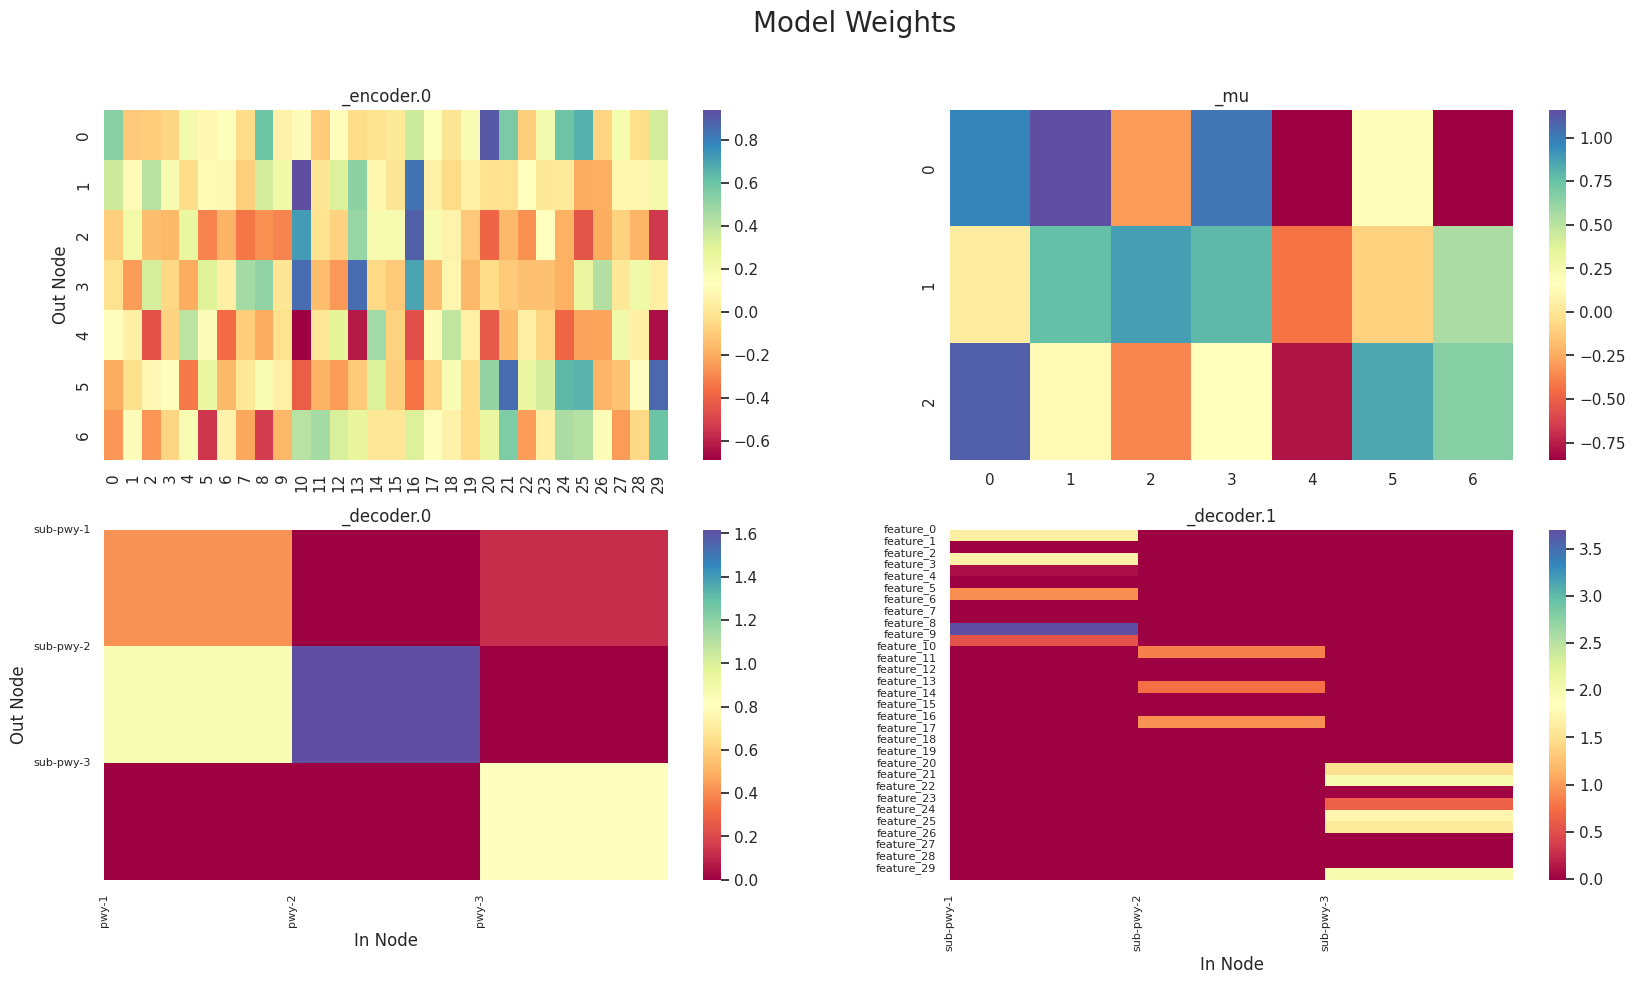

In [ ]:
ontix._visualizer.show_weights()

Creating plots ...


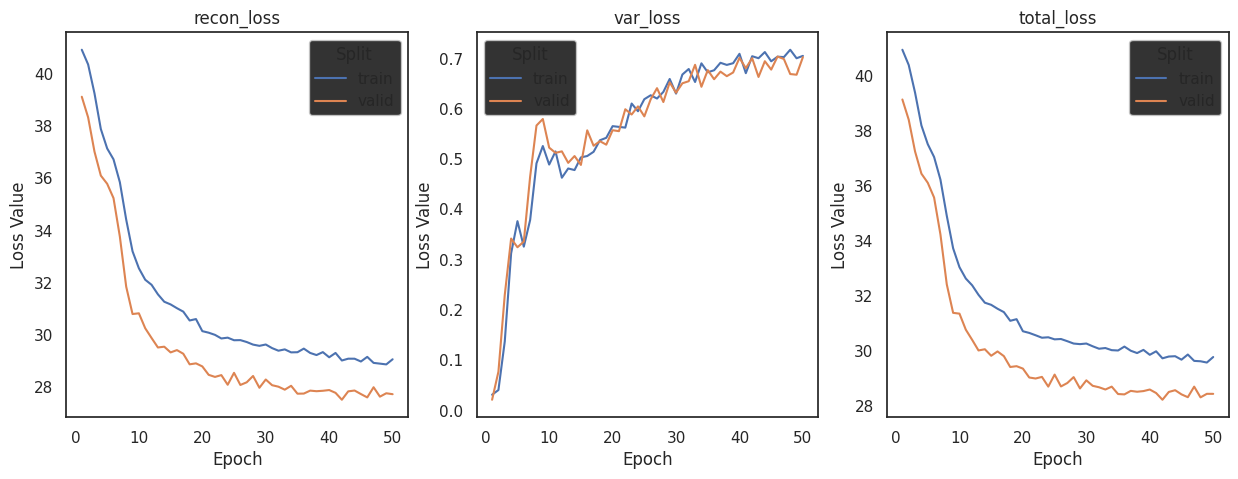

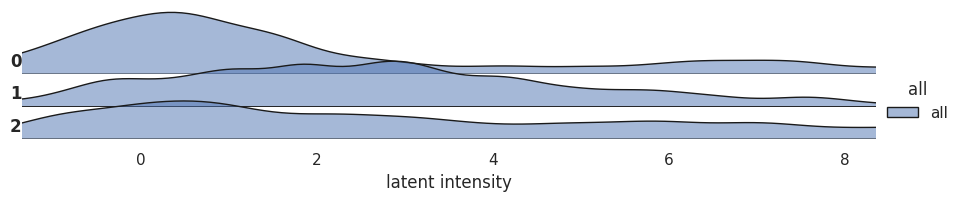

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


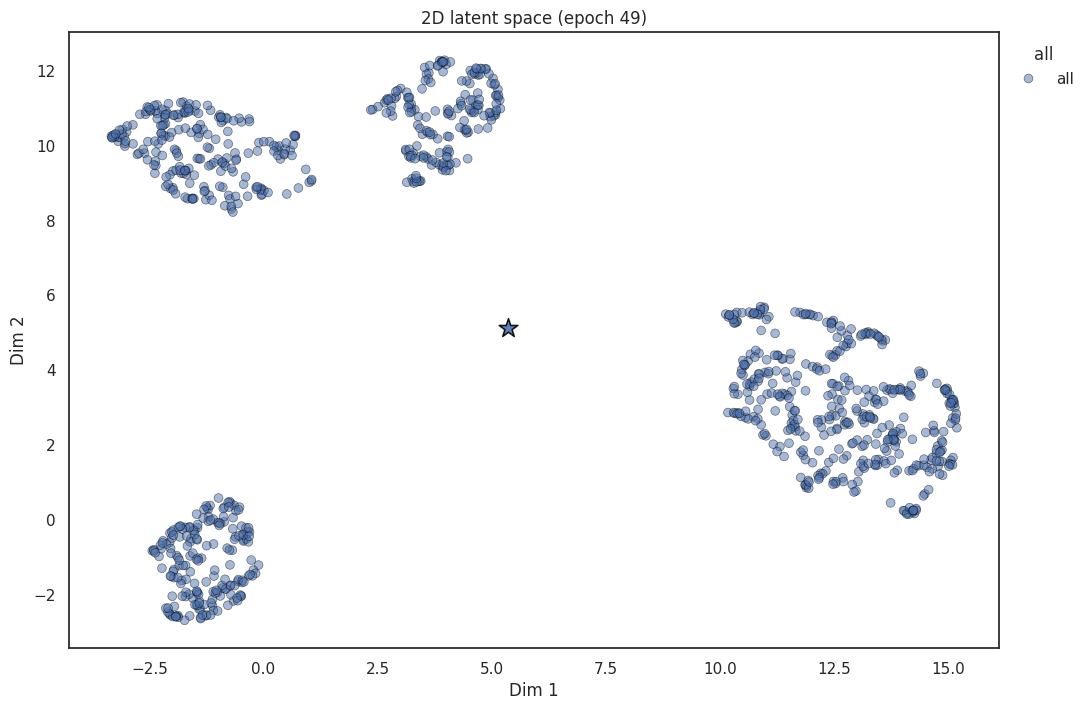

In [ ]:
ontix.show_result()

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


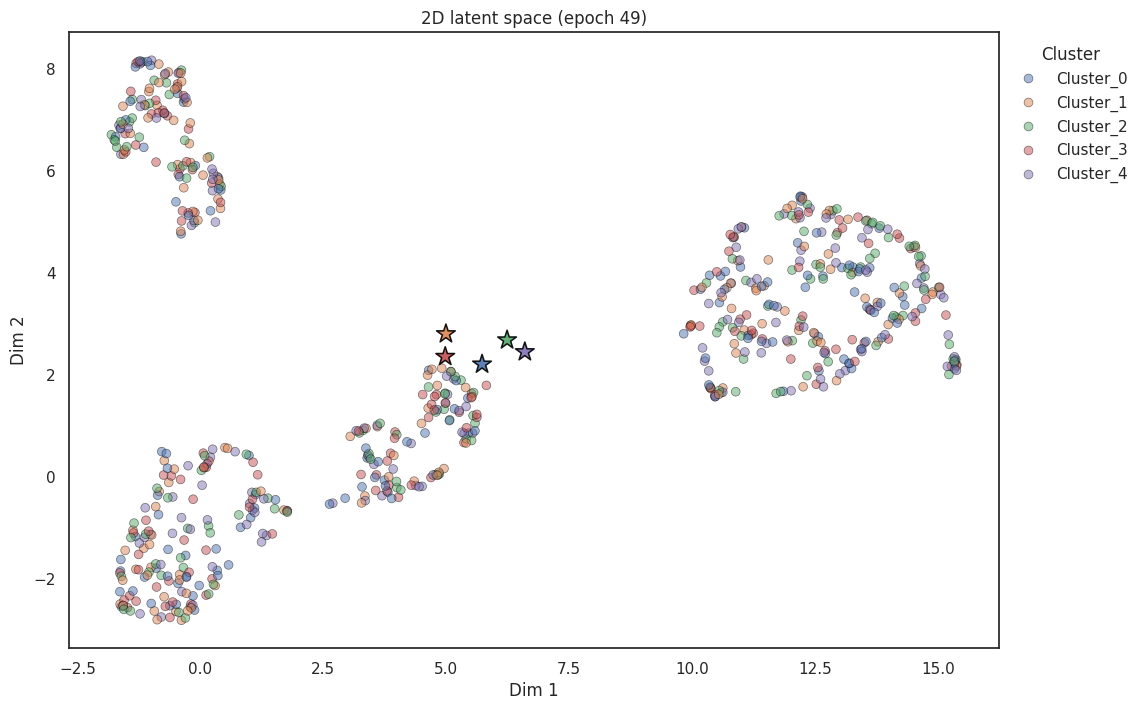

In [ ]:
categorical_clusters = ["Cluster_"+str(c) for c in EXAMPLE_PROCESSED_DATA.train.metadata.cluster]
categorical_clusters
ontix._visualizer.show_latent_space(result=ontix.result,plot_type="2D-scatter", split="train", label_list=categorical_clusters, param="Cluster")

In [ ]:
ontix.ontologies

({'pwy-1': ['sub-pwy-1', 'sub-pwy-2'], 'pwy-2': ['sub-pwy-3', 'sub-pwy-2']},
 {'sub-pwy-1': ['feature_0',
   'feature_1',
   'feature_2',
   'feature_3',
   'feature_4',
   'feature_5',
   'feature_6',
   'feature_7',
   'feature_8',
   'feature_9'],
  'sub-pwy-2': ['feature_10',
   'feature_11',
   'feature_12',
   'feature_13',
   'feature_14',
   'feature_15',
   'feature_16',
   'feature_17',
   'feature_18',
   'feature_19'],
  'sub-pwy-3': ['feature_20',
   'feature_21',
   'feature_22',
   'feature_23',
   'feature_24',
   'feature_25',
   'feature_26',
   'feature_27',
   'feature_28',
   'feature_29']})

In [ ]:
enumerate(ontix.result.model.ontologies)

In [ ]:
ontix.result.model.ontologies[1].keys()

dict_keys(['sub-pwy-1', 'sub-pwy-2', 'sub-pwy-3'])

/tmp/ipykernel_19925/3884008002.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  sns.heatmap(np.array(mask), ax=axes[i], cmap="viridis")
/tmp/ipykernel_19925/3884008002.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  sns.heatmap(np.array(mask), ax=axes[i], cmap="viridis")


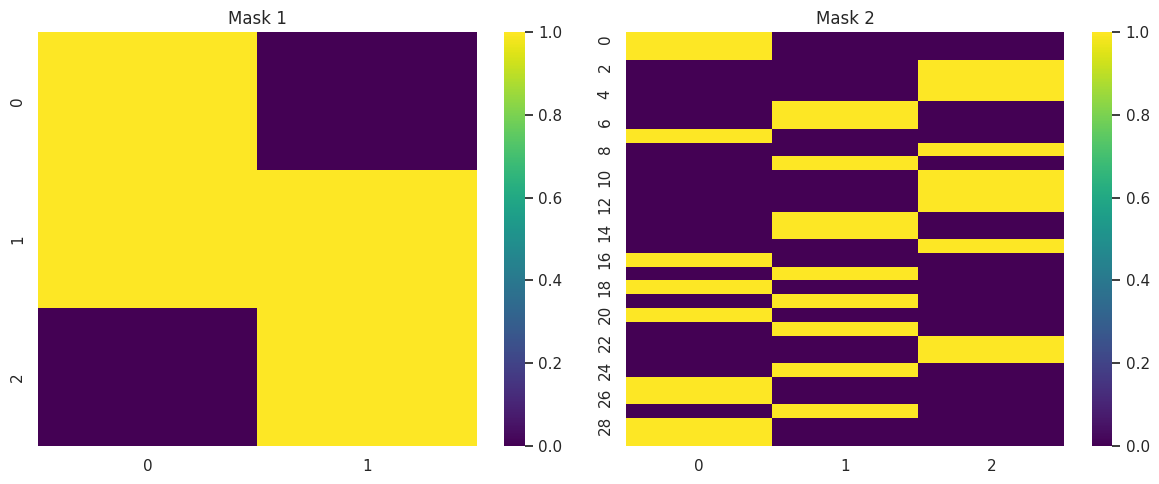

In [ ]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

masks = ontix.result.model.masks

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, mask in enumerate(masks):
	sns.heatmap(np.array(mask), ax=axes[i], cmap="viridis")
	axes[i].set_title(f"Mask {i+1}")
plt.tight_layout()
plt.show()

In [ ]:
ontix.preprocessed_data.train.feature_ids

['feature_0',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_26',
 'feature_27',
 'feature_28',
 'feature_29']

In [ ]:
# Print all available attributes of ontix
print("Attributes of ontix:")
for attr in dir(ontix):
	if not attr.startswith("__"):
		print(attr)


Attributes of ontix:
_abc_impl
_data_splitter
_dataset_type
_datasets
_evaluator
_fill_data_info
_handle_direct_user_data
_loss_type
_model_type
_preprocessor
_preprocessor_type
_trainer
_trainer_type
_validate_config_data
_validate_container
_validate_raw_user_data
_validate_user_data
_visualizer
config
decode
evaluate
fit
load
ontologies
predict
preprocess
preprocessed_data
raw_user_data
result
run
sample_latent_space
save
show_result
visualize


/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


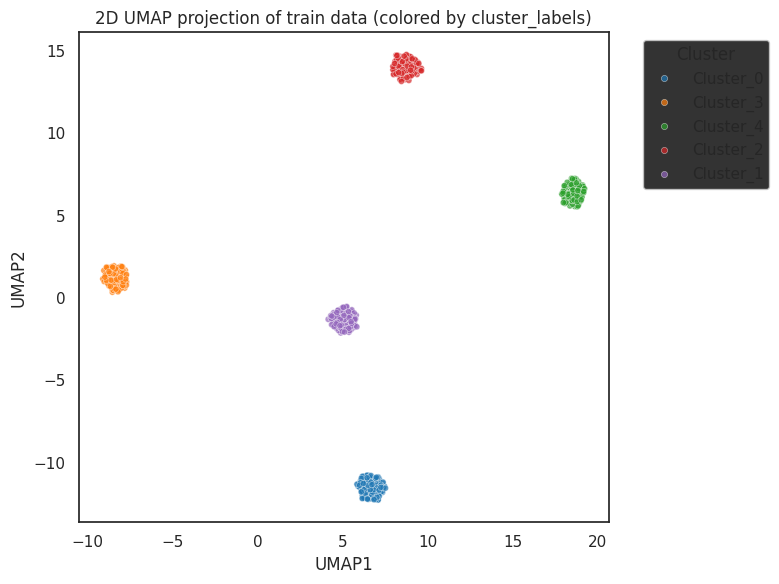

In [ ]:
import seaborn as sns
import pandas as pd
import umap
import matplotlib.pyplot as plt


# Fit UMAP to reduce to 2D
umap_2d_seaborn = umap.UMAP(n_components=2, random_state=42)
embedding_seaborn = umap_2d_seaborn.fit_transform(EXAMPLE_PROCESSED_DATA.train.data)

# Create a DataFrame for plotting
umap_df = pd.DataFrame({
	"UMAP1": embedding_seaborn[:, 0],
	"UMAP2": embedding_seaborn[:, 1],
	"Cluster": categorical_clusters
})

plt.figure(figsize=(8, 6))
sns.scatterplot(
	data=umap_df,
	x="UMAP1",
	y="UMAP2",
	hue="Cluster",
	palette="tab10",
	s=20,
	alpha=0.7
)
plt.title("2D UMAP projection of train data (colored by cluster_labels)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()